# Playing with model editing

In [2]:
from pathlib import Path
if Path().resolve().name == "notebooks":
    %cd ..
%ls
import sys
sys.path.append("models")
sys.path.append("data")
sys.path.append("concepts")

/Users/dgcnz/development/uva/fact/FACT
LICENSE                               lightning_logs/
README.md                             logs/
a.py                                  model_editing.out
accuracies.csv                        models/
accuracies2.csv                       notebook/
accuracies_final.csv                  notebooks/
accuracies_rn18.csv                   old_logs/
artifacts/                            poetry.lock
assets/                               pyproject.toml
concepts/                             scripts/
configs/                              slurm/
data/                                 test_cav_activation.py
debug.log                             test_different_projections.py
debug_finakl.log                      testnotebook.ipynb
debug_rn18.log                        train_pcbm.py
docs/                                 train_pcbm_h.py
environment.yaml                      train_pcbm_userstudy.py
evaluate_og_model.py                  training_tools/
experiments/ 

/Users/dgcnz/development/uva/fact/FACT/.venv/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [25]:
from concepts import ConceptBank
import pickle
import torch
from models.pcbm_pl import PCBMClassifierTrainer
from lightning import Trainer
from data.metashift import MetaShiftDataModule, PreprocessorEnum
from data.metashift import NNProjector
from models.clip_encoder import CLIPImageEncoder
from lightning.pytorch import seed_everything
from models.resnet import ResNet18FeatureExtractor
import matplotlib.pyplot as plt
from models.pcbm_pl import analyze_classifier
from renumics import spotlight
from copy import deepcopy
import torchmetrics
from torchmetrics.classification import MulticlassConfusionMatrix, MulticlassAccuracy

In [26]:
import logging
logging.basicConfig(level=logging.INFO)

In [27]:
# ckpt_path = Path("lightning_logs/task_1_bed_dog_cat/seed_55/version_0/checkpoints/epoch=9-step=320.ckpt") # lam 0.05
# ckpt_path = Path("lightning_logs/task_2_table_dog_cat/seed_42/version_23/checkpoints/epoch=9-step=320.ckpt") # lam 1.7
ckpt_path = Path("lightning_logs/task_1_bed_dog_cat/seed_101010/version_0/checkpoints/epoch=29-step=960.ckpt") # lam 10
concept_bank_path = Path("artifacts/outdir/broden_resnet18_imagenet1k_v1_0.1_50.pkl")
task_name = ckpt_path.parents[3].name

In [28]:
metashift = MetaShiftDataModule(
    task_name=task_name,
    projector=NNProjector(
        concept_bank_path=concept_bank_path,
        backbone=ResNet18FeatureExtractor(),
    ),
    preprocessor_name=PreprocessorEnum.RESNET18_IMAGENET_1K_V1,
    train_batch_size=16,
    test_batch_size=64
)
metashift.setup("train")
class_names = metashift.dataset["train"].info.features["label"].names
concept_names = metashift.projector.concept_names

INFO:root:Attempting to load fact-40/pcbm_metashift/task_1_bed_dog_cat from cache .cache/fact-40/pcbm_metashift/task_1_bed_dog_cat/broden_resnet18_imagenet1k_v1_0.1_50
INFO:root:Loaded fact-40/pcbm_metashift/task_1_bed_dog_cat from cache .cache/fact-40/pcbm_metashift/task_1_bed_dog_cat/broden_resnet18_imagenet1k_v1_0.1_50


Concept Bank is initialized.


In [29]:
spurious_class, source_concept, target_concept = task_name.split("_")[2:5]
spurious_class_ix = class_names.index(spurious_class)
source_concept_ix = concept_names.index(source_concept)
target_concept_ix = concept_names.index(target_concept)
print(f"{spurious_class}@{spurious_class_ix}: {source_concept}@{source_concept_ix}->{target_concept}@{target_concept_ix}")

bed@1: dog@72->cat@50


In [30]:
trained_pcbm = PCBMClassifierTrainer.load_from_checkpoint(ckpt_path)

INFO:root:Calling custom load_state_dict with []


In [31]:
trained_pcbm_pruned = PCBMClassifierTrainer.load_from_checkpoint(ckpt_path, pruned_concept_class_pairs=[(source_concept_ix, spurious_class_ix)])
# trained_pcbm_pruned_normalized = PCBMClassifierTrainer.load_from_checkpoint(ckpt_path, pruned_concept_class_pairs=[(50, 1)], normalize=True)

INFO:root:Calling custom load_state_dict with [(72, 1)]
INFO:root:Pruned 72 1 from 1.6530123949050903 to 0.0


In [60]:
# og_model_path = "artifacts/outdir/pcbm_metashift_task_1_bed_dog_cat__resnet18_imagenet1k_v1__broden_resnet18_imagenet1k_v1_0__lam:0.002__alpha:0.99__seed:100.ckpt"
# og_model_path = "artifacts/outdir/pcbm_metashift_task_1_bed_dog_cat__resnet18_imagenet1k_v1__broden_resnet18_imagenet1k_v1_0__lam:0.05__alpha:0.99__seed:101010.ckpt"
og_model_path = "artifacts/outdir/pcbm_metashift_task_1_bed_dog_cat__resnet18_imagenet1k_v1__broden_resnet18_imagenet1k_v1_0__lam:0.0005__alpha:0.99__seed:0.ckpt"
with open(og_model_path, "rb") as f:
    og_model = torch.load(f)

og_model_pruned = deepcopy(og_model)
with torch.no_grad():
    og_model_pruned.classifier.weight[spurious_class_ix, source_concept_ix] = 0.0

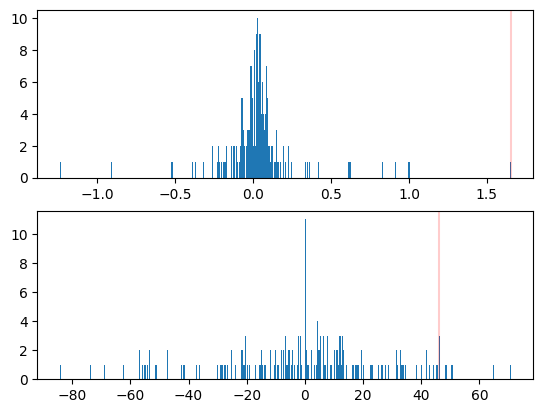

In [67]:
fig, axes = plt.subplots(2)
_ =  axes[0].hist(trained_pcbm.model.classifier.weight[spurious_class_ix].reshape(-1).cpu().detach().numpy(), bins=400)
axes[0].axvline(x=trained_pcbm.model.classifier.weight[spurious_class_ix, source_concept_ix].item(), c="r", alpha=0.2)
_ = axes[1].hist(og_model.classifier.weight[spurious_class_ix].reshape(-1).cpu().detach().numpy(), bins=400)
axes[1].axvline(x=og_model.classifier.weight[spurious_class_ix, source_concept_ix].item(), c="r", alpha=0.2)


In [62]:
source_concept_ix

72

In [35]:
print(analyze_classifier(trained_pcbm.model, class_names=class_names, concept_names=concept_names))

Class : airplane
	 1 - body: 2.529
	 2 - airplane: 2.158
	 3 - door_frame: 1.774
	 4 - mountain: 1.442
	 5 - painted: 0.959
Class : bed
	 1 - dog: 1.653
	 2 - sofa: 1.009
	 3 - paw: 1.000
	 4 - armchair: 0.912
	 5 - bedclothes: 0.836
Class : car
	 1 - ashcan: 0.966
	 2 - car: 0.938
	 3 - base: 0.744
	 4 - bus: 0.611
	 5 - fan: 0.606
Class : cow
	 1 - horse: 2.166
	 2 - headboard: 1.485
	 3 - cow: 1.415
	 4 - cup: 1.300
	 5 - napkin: 1.000
Class : keyboard
	 1 - keyboard: 2.793
	 2 - box: 0.753
	 3 - figurine: 0.615
	 4 - bookcase: 0.595
	 5 - polka_dots: 0.414


In [49]:
print(trained_pcbm_pruned.model.classifier.weight[spurious_class_ix, source_concept_ix])
print(analyze_classifier(trained_pcbm_pruned.model, class_names=class_names, concept_names=concept_names))

tensor(0., grad_fn=<SelectBackward0>)
Class : airplane
	 1 - body: 2.529
	 2 - airplane: 2.158
	 3 - door_frame: 1.774
	 4 - mountain: 1.442
	 5 - painted: 0.959
Class : bed
	 1 - sofa: 1.009
	 2 - paw: 1.000
	 3 - armchair: 0.912
	 4 - bedclothes: 0.836
	 5 - cushion: 0.622
Class : car
	 1 - ashcan: 0.966
	 2 - car: 0.938
	 3 - base: 0.744
	 4 - bus: 0.611
	 5 - fan: 0.606
Class : cow
	 1 - horse: 2.166
	 2 - headboard: 1.485
	 3 - cow: 1.415
	 4 - cup: 1.300
	 5 - napkin: 1.000
Class : keyboard
	 1 - keyboard: 2.793
	 2 - box: 0.753
	 3 - figurine: 0.615
	 4 - bookcase: 0.595
	 5 - polka_dots: 0.414


In [59]:
print(og_model.analyze_classifier())

Class : airplane
	 1 - jar: 0.625
	 2 - foot: 0.291
	 3 - paper: 0.287
	 4 - bumper: 0.237
	 5 - loudspeaker: 0.083
Class : bed
	 1 - board: 0.585
	 2 - ground: 0.383
	 3 - bucket: 0.176
	 4 - air_conditioner: 0.000
	 5 - airplane: 0.000
Class : car
	 1 - door: 0.400
	 2 - hill: 0.348
	 3 - desk: 0.235
	 4 - blackness: 0.193
	 5 - bedroom_s: 0.090
Class : cow
	 1 - pipe: 0.400
	 2 - light: 0.328
	 3 - palm: 0.314
	 4 - minibike: 0.213
	 5 - armchair: 0.176
Class : keyboard
	 1 - sofa: 0.634
	 2 - book: 0.494
	 3 - napkin: 0.472
	 4 - cabinet: 0.027
	 5 - air_conditioner: 0.000


In [38]:
print(og_model_pruned.analyze_classifier())

Class : airplane
	 1 - countertop: 48.426
	 2 - jar: 42.834
	 3 - head: 29.735
	 4 - paper: 28.554
	 5 - pillow: 27.190
Class : bed
	 1 - board: 40.023
	 2 - greenness: 29.714
	 3 - car: 27.039
	 4 - bench: 24.294
	 5 - cardboard: 23.639
Class : car
	 1 - neck: 30.661
	 2 - cat: 25.697
	 3 - refrigerator: 25.192
	 4 - desk: 21.744
	 5 - ear: 19.086
Class : cow
	 1 - person: 31.037
	 2 - pipe: 21.502
	 3 - base: 20.145
	 4 - box: 18.387
	 5 - dining_room_s: 18.192
Class : keyboard
	 1 - balcony: 26.593
	 2 - ottoman: 24.818
	 3 - outside_arm: 23.447
	 4 - exhaust_hood: 21.941
	 5 - sofa: 18.957


In [45]:
# ds = datasets.load_dataset("fact-40/pcbm_metashift", name=task_name)
# spotlight.show(ds["train"])
# spotlight.show(ds["test"])

In [46]:
x = og_model.classifier.weight[4].detach().cpu().reshape(-1).numpy().tolist()
a = dict(list(sorted(zip(concept_names, x), key=lambda item: item[1], reverse=True)))

In [42]:
og_model.classifier.weight[spurious_class_ix, source_concept_ix]

tensor(0., device='mps:0', grad_fn=<SelectBackward0>)

In [72]:
# with torch.no_grad():
#     trained_pcbm_pruned.model.classifier.weight[1, 50] = 0.
#     trained_pcbm_pruned_normalized.model.classifier.weight[1, 50] = 0.
# with torch.no_grad():
#      trained_pcbm.model.classifier.weight = og_model.classifier.weight
#      trained_pcbm_pruned.model.classifier.weight = og_model.classifier.weight
#      trained_pcbm_pruned.model.classifier.weight[4, 72] = 0.0
#     trained_pcbm_pruned_normalized.model.classifier.weight = og_model.classifier.weight
from torchvision import transforms
with torch.no_grad():
    trained_pcbm.to("cpu")
    trained_pcbm_pruned.to("cpu")
    og_model.to("cpu")
    og_model_pruned.to("cpu")
    # trained_pcbm_pruned_normalized.to("cpu")
    base_cm = MulticlassConfusionMatrix(num_classes=5, normalize="none")
    pruned_cm = MulticlassConfusionMatrix(num_classes=5, normalize="none")
    base_acc = MulticlassAccuracy(num_classes=5)
    pruned_acc = MulticlassAccuracy(num_classes=5)

    base_og_cm = MulticlassConfusionMatrix(num_classes=5, normalize="none")
    pruned_og_cm = MulticlassConfusionMatrix(num_classes=5, normalize="none")
    base_og_acc = MulticlassAccuracy(num_classes=5)
    pruned_og_acc = MulticlassAccuracy(num_classes=5)
    # norm_cm = MulticlassConfusionMatrix(num_classes=5, normalize="none")

    batch = metashift.dataset["train"]
    inputs = batch["concept_weights"]
    targets = batch["label"]

    base_preds = trained_pcbm(batch)
    base_cm(base_preds, targets)
    print(base_acc(base_preds, targets))

    pruned_preds = trained_pcbm_pruned(batch)
    pruned_cm(pruned_preds, targets)
    print(pruned_acc(pruned_preds, targets))

    base_og_preds = og_model.classifier(inputs)
    base_og_cm(base_og_preds, targets)
    print(base_og_acc(base_og_preds, targets))

    pruned_og_preds = og_model_pruned.classifier(inputs)
    pruned_og_cm(pruned_og_preds, targets)
    print(pruned_og_acc(pruned_og_preds, targets))

fig, axes = plt.subplots(2, 2,)# figsize=(12, 8))
base_cm.plot(ax=axes[0][0])
axes[0][0].title.set_text("Base")
pruned_cm.plot(ax=axes[0][1])
axes[0][1].title.set_text("Pruned")

base_og_cm.plot(ax=axes[1][0])
axes[1][0].title.set_text("Base")
pruned_og_cm.plot(ax=axes[1][1])
axes[1][1].title.set_text("Pruned")

plt.show()


tensor(0.9060)
tensor(0.9120)


/Users/dgcnz/development/uva/fact/FACT/.venv/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


ValueError: Input and output must have the same number of spatial dimensions, but got input with spatial dimensions of [170] and output size of [879, 299]. Please provide input tensor in (N, C, d1, d2, ...,dK) format and output size in (o1, o2, ...,oK) format.

In [ ]:
metashift.

In [50]:
base_cm = MulticlassConfusionMatrix(num_classes=5, normalize="none")
base

In [66]:
base_cm.update(base_preds, targets)

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Predicted class', ylabel='True class'>)

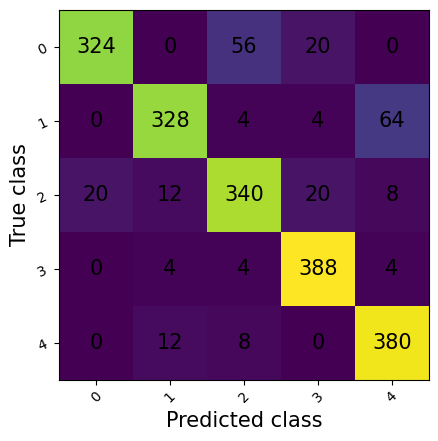

In [67]:
base_cm.plot()

In [58]:
base_cm.reset()

In [191]:
print(base_preds[2])
print(pruned_preds[2])

tensor([ -96.3905, -206.2929,   98.1887, -141.7721,   -7.0952])
tensor([ -96.3905, -206.2929,   98.1887, -141.7721,   -7.0952])


In [86]:
class_names

['airplane', 'bed', 'car', 'cow', 'keyboard']

In [21]:
trainer = Trainer(deterministic=True)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [22]:
SEED = 55

In [23]:
seed_everything(SEED)
trainer.test(trained_pcbm, metashift)

Seed set to 55
INFO:root:Attempting to load fact-40/pcbm_metashift/task_1_bed_cat_dog from cache .cache/fact-40/pcbm_metashift/task_1_bed_cat_dog/broden_resnet18_imagenet1k_v1_0.1_50
INFO:root:Loaded fact-40/pcbm_metashift/task_1_bed_cat_dog from cache .cache/fact-40/pcbm_metashift/task_1_bed_cat_dog/broden_resnet18_imagenet1k_v1_0.1_50
/Users/dgcnz/development/uva/fact/FACT/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8040000200271606     │
└───────────────────────────┴───────────────────────────┘

[{'test_accuracy': 0.8040000200271606}]

In [8]:
pcbm_trainer = PCBMClassifierTrainer(n_concepts=170, n_classes=5, lr=0.05, lam=0.05, alpha=0.99)


In [10]:
seed_everything(42)
trainer = Trainer(deterministic=True, max_epochs=30)

Seed set to 42
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [60]:
seed = 100

In [61]:
seed_everything(seed)
trainer.fit(pcbm_trainer, metashift)

Seed set to 100

  | Name  | Type           | Params
-----------------------------------------
0 | model | PCBMClassifier | 855   
1 | loss  | PCBMLoss       | 855   
-----------------------------------------
855       Trainable params
0         Non-trainable params
855       Total params
0.003     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


In [62]:
seed_everything(seed)
out = trainer.test(pcbm_trainer, metashift)

Seed set to 100
/Users/dgcnz/development/uva/fact/FACT/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8939999938011169     │
└───────────────────────────┴───────────────────────────┘

In [63]:
print(out)

[{'test_accuracy': 0.8939999938011169}]


In [64]:
trainer.checkpoint_callback.best_model_path

'/Users/dgcnz/development/uva/fact/FACT/lightning_logs/version_1/checkpoints/epoch=29-step=960.ckpt'

In [65]:
pcbm_trainer_pruned = PCBMClassifierTrainer.load_from_checkpoint(trainer.checkpoint_callback.best_model_path,
                                                          pruned_concept_class_pairs=[(128, 1)]
                                                         )

In [66]:
pcbm_trainer_pruned.model.classifier.weight[1, 128]

tensor(0., device='mps:0', grad_fn=<SelectBackward0>)

In [67]:
pcbm_trainer.model.classifier.weight[1, 128]

tensor(1.2930, grad_fn=<SelectBackward0>)

In [68]:
seed_everything(seed)
pruned_out = trainer.test(pcbm_trainer_pruned, metashift)

Seed set to 100


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8980000019073486     │
└───────────────────────────┴───────────────────────────┘

In [16]:
path = Path("lightning_logs/task_1_bed_dog_cat/seed_42/version_6/checkpoints/epoch=19-step=640.ckpt")
print(path)
pcbm = PCBMClassifierTrainer.load_from_checkpoint(str(path))

lightning_logs/task_1_bed_dog_cat/seed_42/version_6/checkpoints/epoch=19-step=640.ckpt


In [4]:
from models.resnet import ResNet18FeatureExtractor

In [8]:
CONCEPT_BANK = "artifacts/outdir/broden_resnet18_imagenet1k_v1_0.1_50.pkl"
all_concepts = pickle.load(open(CONCEPT_BANK, 'rb'))
all_concept_names = list(all_concepts.keys())
concept_bank = ConceptBank(all_concepts, args.device)

Concept Bank is initialized.


In [11]:
metashift_resnet18 = MetaShiftDataModule(
    task_name="task_1_bed_dog_cat",
    projector=NNProjector(
        concept_bank_path="artifacts/outdir/broden_resnet18_imagenet1k_v1_0.1_50.pkl",
        backbone=ResNet18FeatureExtractor(),
    ),
    preprocessor_name=PreprocessorEnum.RESNET18_IMAGENET_1K_V1,
    train_batch_size=16,
    test_batch_size=64
)
metashift_resnet18.setup("test")

Concept Bank is initialized.


In [12]:
metashift_resnet50 = MetaShiftDataModule(
    task_name="task_1_bed_dog_cat",
    projector=NNProjector(
        concept_bank_path="artifacts/outdir/broden_clip_RN50_10.0_50.pkl",
        backbone=CLIPImageEncoder(model_name="RN50"),
    ),
    preprocessor_name=PreprocessorEnum.CLIP_RESNET50,
    train_batch_size=16,
    test_batch_size=64
)
metashift_resnet50.setup("test")

Concept Bank is initialized.


In [8]:
import pickle
with open("artifacts/outdir/broden_clip_RN50_10.0_50.pkl", "rb") as f:
    concept_dict = pickle.load(f)

dict

In [14]:
cons = ["cat", "dog", "book"]
for con in cons:
    print(metashift_resnet18.projector.concept_names.index(con))

50
72
30


In [15]:
for con in cons:
    print(metashift_resnet50.projector.concept_names.index(con))

50
72
30


In [18]:
pcbm.model.classifier.weight[1, 72]

tensor(-0.3531, device='mps:0', grad_fn=<SelectBackward0>)

In [17]:
s =analyze_classifier(
    pcbm.model,
    concept_names=metashift_resnet18.projector.concept_names,
    class_names=metashift_resnet18.dataset["train"].info.features["label"].names,
)
print(s)

Class : airplane
	 1 - jar: 2.947
	 2 - pillow: 1.865
	 3 - ceramic: 1.854
	 4 - hair: 1.734
	 5 - paper: 1.538
Class : bed
	 1 - mouse: 2.838
	 2 - clock: 2.642
	 3 - bus: 2.136
	 4 - balcony: 1.924
	 5 - bicycle: 1.461
Class : car
	 1 - handle: 1.552
	 2 - chandelier: 1.310
	 3 - headlight: 1.309
	 4 - bench: 1.294
	 5 - fireplace: 1.251
Class : cow
	 1 - redness: 1.824
	 2 - field: 1.820
	 3 - bird: 1.780
	 4 - bedclothes: 1.732
	 5 - minibike: 1.701
Class : keyboard
	 1 - sofa: 2.877
	 2 - laminate: 2.399
	 3 - bicycle: 2.219
	 4 - blotchy: 1.948
	 5 - air_conditioner: 1.788


In [10]:
concept_bank.concept_info.concept_names

['cat',
 'paper',
 'apron',
 'microwave',
 'tree',
 'pane',
 'lamp',
 'polka_dots',
 'flowerpot',
 'fluorescent',
 'hand',
 'drawer',
 'fireplace',
 'figurine',
 'blind',
 'bench',
 'basket',
 'footboard',
 'chandelier',
 'handle_bar',
 'flag',
 'bedclothes',
 'drinking_glass',
 'car',
 'chain_wheel',
 'can',
 'balcony',
 'eye',
 'bed',
 'pipe',
 'box',
 'cup',
 'manhole',
 'granite',
 'desk',
 'back',
 'greenness',
 'cushion',
 'ceramic',
 'water',
 'dog',
 'plant',
 'board',
 'handle',
 'metal',
 'foot',
 'concrete',
 'armchair',
 'curtain',
 'ground',
 'person',
 'pedestal',
 'grass',
 'stripes',
 'flower',
 'bridge',
 'ottoman',
 'blotchy',
 'redness',
 'coffee_table',
 'path',
 'cardboard',
 'cabinet',
 'laminate',
 'jar',
 'body',
 'outside_arm',
 'oven',
 'pack',
 'chair',
 'exhaust_hood',
 'napkin',
 'paw',
 'bus',
 'chest_of_drawers',
 'hill',
 'plate',
 'frame',
 'nose',
 'mouth',
 'column',
 'doorframe',
 'headlight',
 'loudspeaker',
 'motorbike',
 'inside_arm',
 'pillar',
 

In [ ]:
analyze_classifier(pcbm.model, class_names=)

In [ ]:
cktp_path ="lightning_logs/task_1_bed_cat_dog/seed_55/version_0/checkpoints/epoch=320.ckpt"
